<a href="https://colab.research.google.com/github/Tanainan/Covid-19Thailand/blob/main/Covid_python_LR%2C_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [1]:
!pip install -U tensorflow-addons
from numpy import hstack
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
from statistics import stdev
from statistics import mean
from matplotlib import pyplot
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
from matplotlib import pyplot as plt
import datetime as dt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from statsmodels.graphics.factorplots import interaction_plot
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
import itertools
!pip install -U scikit-learn
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.utils import to_categorical
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from warnings import simplefilter
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


### Data

In [3]:
data = read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/new_cases.csv")

data = pd.DataFrame(data)

# select columns
data = data[["date", "Thailand"]]

# change column name
data = data.rename(columns = {'date':'Date', 'Thailand':'Cases_daily'})

# # change date format
data.Date =  pd.to_datetime(data["Date"])

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
data[["Cases_daily"]] = data[["Cases_daily"]].replace(np.nan, 0)

# start from 15/6/2021
data = data[data.loc[data['Date'] == "2021-06-15"].index[0]:]

# reset index
data_i = data.reset_index(drop = True)


In [4]:
data = read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/new_deaths.csv")

data = pd.DataFrame(data)

# select columns
data = data[["date", "Thailand"]]

# change column name
data = data.rename(columns = {'date':'Date', 'Thailand':'Deaths_daily'})

# # change date format
data.Date =  pd.to_datetime(data["Date"])

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
data[["Deaths_daily"]] = data[["Deaths_daily"]].replace(np.nan, 0)

# start from 15/6/2021
data = data[data.loc[data['Date'] == "2021-06-15"].index[0]:]

# # reset index
data_d = data.reset_index(drop = True)


In [5]:
window = 2 # for moving average
days_predicted = 14

# moving average
data_i['Cases_daily2'] = data_i.Cases_daily
data_i['Cases_daily'] = data_i.Cases_daily.rolling(window).mean()

data_d['Deaths_daily2'] = data_d.Deaths_daily
data_d['Deaths_daily'] = data_d.Deaths_daily.rolling(window).mean()


# remove NaN
data_i.dropna(subset = ["Cases_daily"], inplace=True)
data_d.dropna(subset = ["Deaths_daily"], inplace=True)

data_i = data_i.reset_index(drop = True)
data_d = data_d.reset_index(drop = True)



# Linear Regression

## Cases

MAPE = 0.2016622175363694


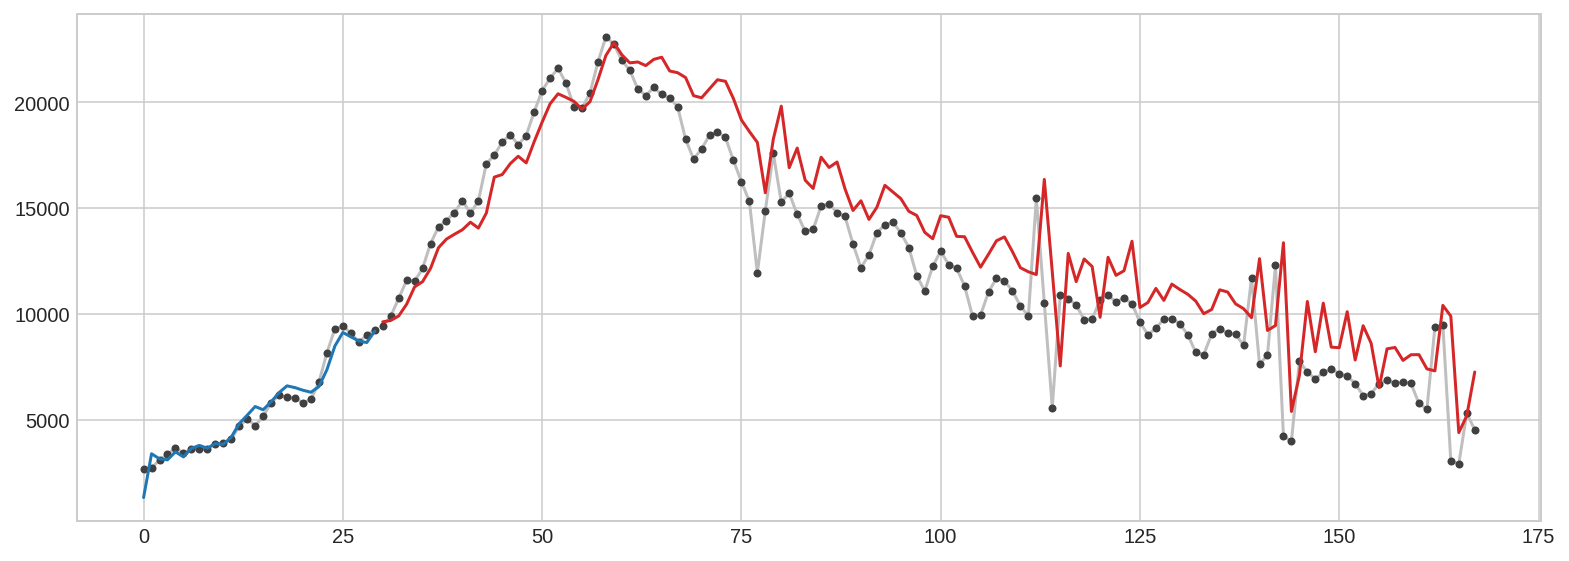

In [6]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X_i = make_lags(data_i.Cases_daily, lags=14)
X_i = X_i.fillna(0.0)

# Create target series and data splits
y_i = data_i.Cases_daily.copy()
X_i_train, X_i_test, y_i_train, y_i_test = train_test_split(X_i, y_i, train_size=30, shuffle=False)

model_lr_i = LinearRegression() 
model_lr_i.fit(X_i_train, y_i_train)
y_pred_lr_i = pd.Series(model_lr_i.predict(X_i_train), index=y_i_train.index)
y_fore_lr_i = pd.Series(model_lr_i.predict(X_i_test), index=y_i_test.index)

mape_lr_i = mean_absolute_percentage_error(y_i_test, y_fore_lr_i)

print("MAPE =", mape_lr_i)

ax = y_i_train.plot(**plot_params)
ax = y_i_test.plot(**plot_params)
ax = y_pred_lr_i.plot(ax=ax)
_ = y_fore_lr_i.plot(ax=ax, color='C3')

## Deaths

MAPE = 0.26407695369958256


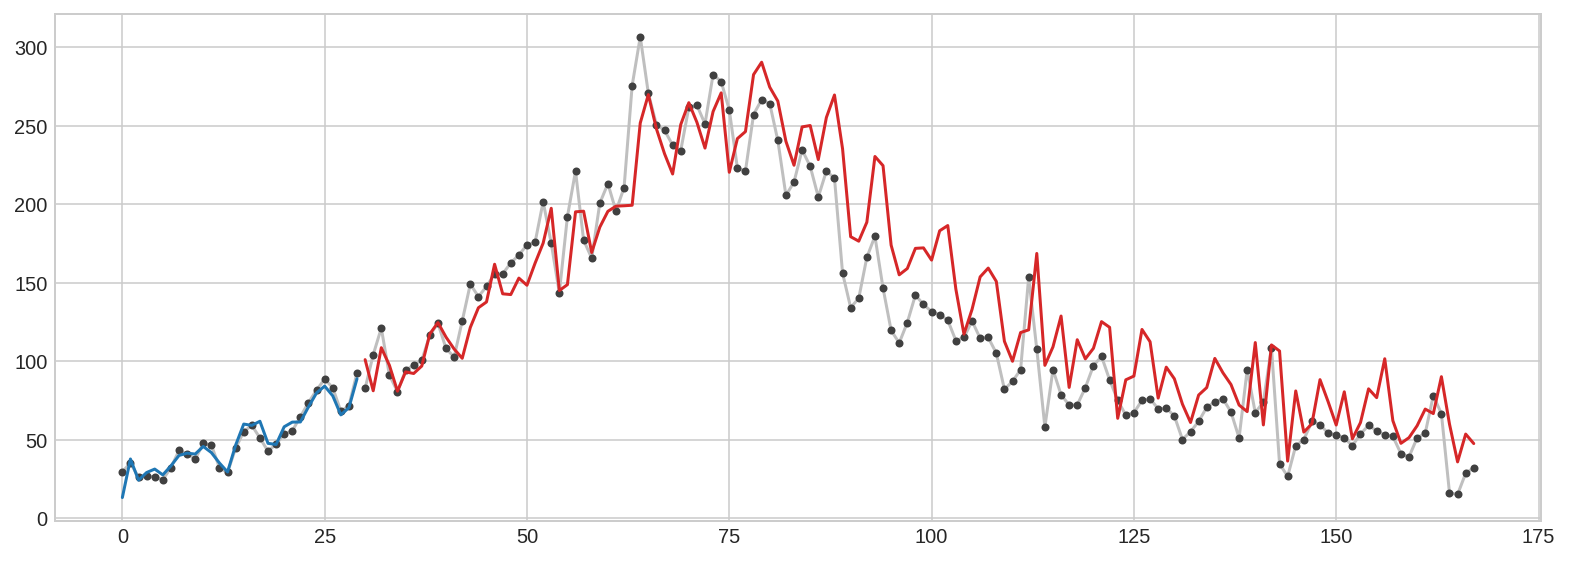

In [7]:
X_d = make_lags(data_d.Deaths_daily, lags=14)
X_d = X_d.fillna(0.0)

# Create target series and data splits
y_d = data_d.Deaths_daily.copy()
X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(X_d, y_d, train_size=30, shuffle=False)

model_lr_d = LinearRegression() 
model_lr_d.fit(X_d_train, y_d_train)
y_pred_lr_d = pd.Series(model_lr_d.predict(X_d_train), index=y_d_train.index)
y_fore_lr_d = pd.Series(model_lr_d.predict(X_d_test), index=y_d_test.index)

mape_lr_d = mean_absolute_percentage_error(y_d_test, y_fore_lr_d)

print("MAPE =", mape_lr_d)


ax = y_d_train.plot(**plot_params)
ax = y_d_test.plot(**plot_params)
ax = y_pred_lr_d.plot(ax=ax)
_ = y_fore_lr_d.plot(ax=ax, color='C3')

# Ridge Regression

## Cases

MAPE = 0.2016622267067932


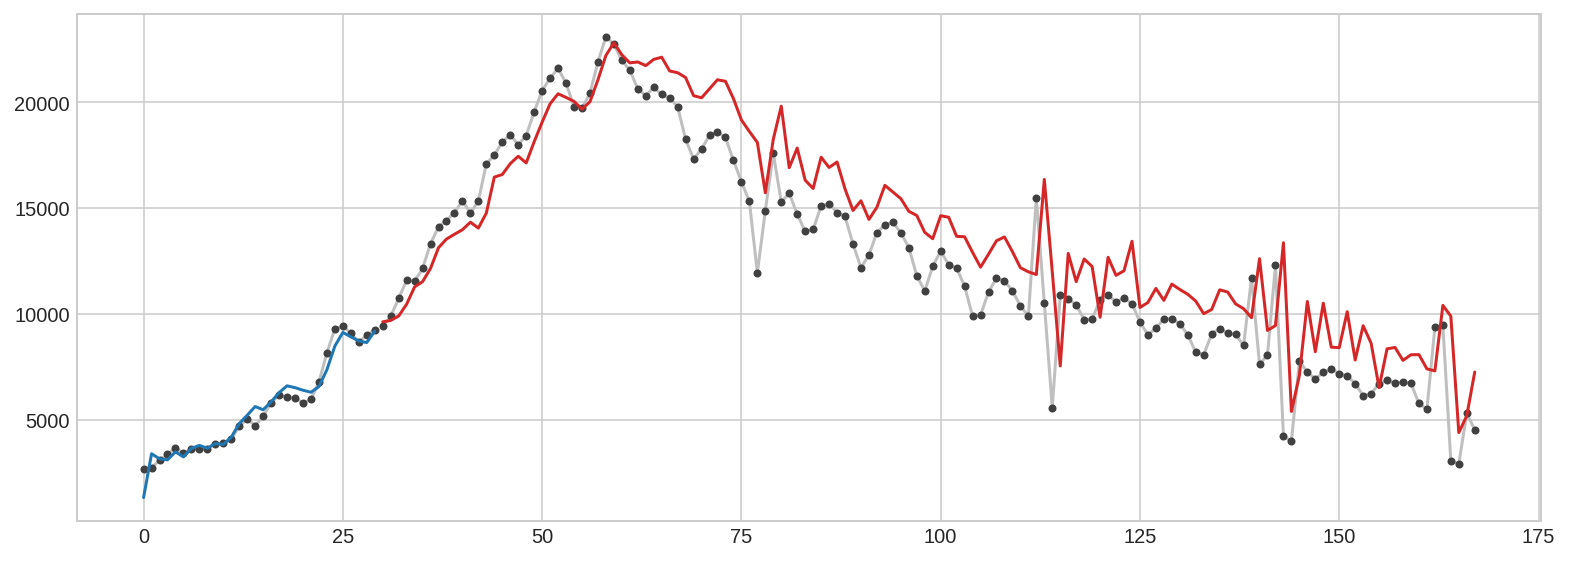

In [8]:
model_rr_i = Ridge() 
model_rr_i.fit(X_i_train, y_i_train)
y_pred_rr_i = pd.Series(model_rr_i.predict(X_i_train), index=y_i_train.index)
y_fore_rr_i = pd.Series(model_rr_i.predict(X_i_test), index=y_i_test.index)

mape_rr_i = mean_absolute_percentage_error(y_i_test, y_fore_rr_i)

print("MAPE =", mape_rr_i)

ax = y_i_train.plot(**plot_params)
ax = y_i_test.plot(**plot_params)
ax = y_pred_rr_i.plot(ax=ax)
_ = y_fore_rr_i.plot(ax=ax, color='C3')

## Deaths

MAPE = 0.26421537537627243


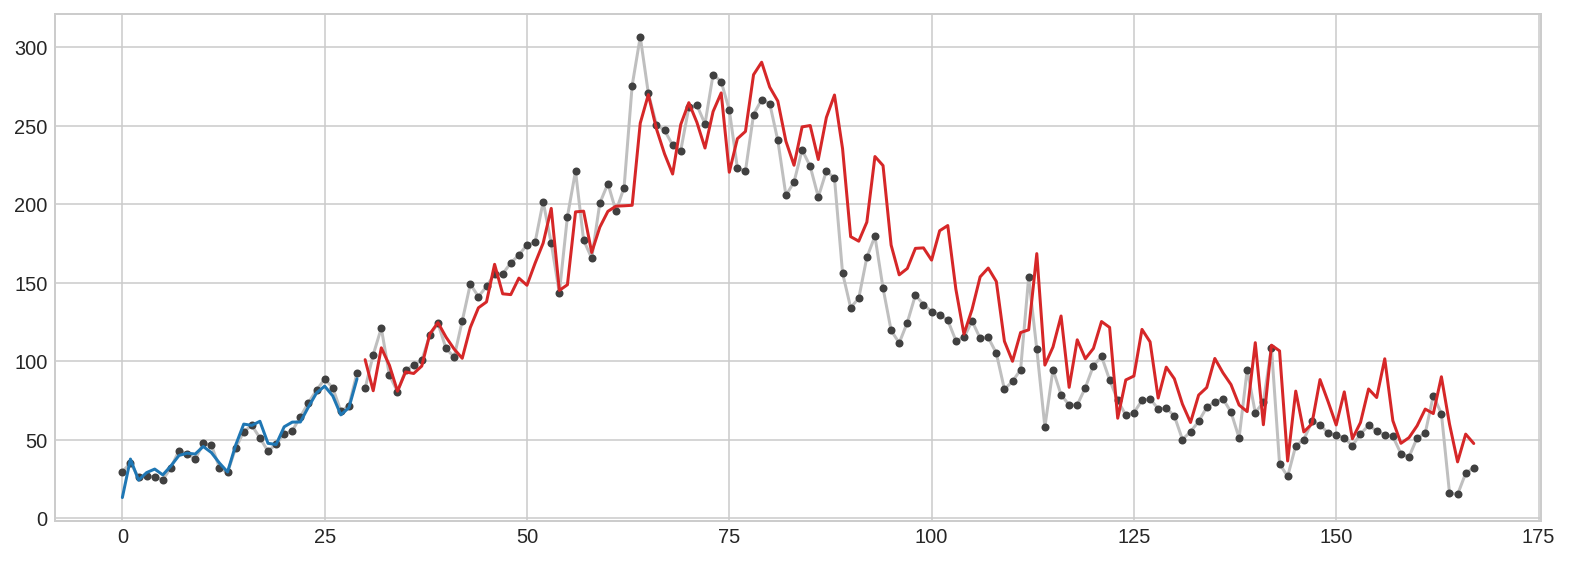

In [9]:

model_rr_d = Ridge()
model_rr_d.fit(X_d_train, y_d_train)
y_pred_rr_d = pd.Series(model_rr_d.predict(X_d_train), index=y_d_train.index)
y_fore_rr_d = pd.Series(model_rr_d.predict(X_d_test), index=y_d_test.index)

mape_rr_d = mean_absolute_percentage_error(y_d_test, y_fore_rr_d)

print("MAPE =", mape_rr_d)


ax = y_d_train.plot(**plot_params)
ax = y_d_test.plot(**plot_params)
ax = y_pred_rr_d.plot(ax=ax)
_ = y_fore_rr_d.plot(ax=ax, color='C3')

# Lasso Regression

## Cases

MAPE = 0.20166216958314553


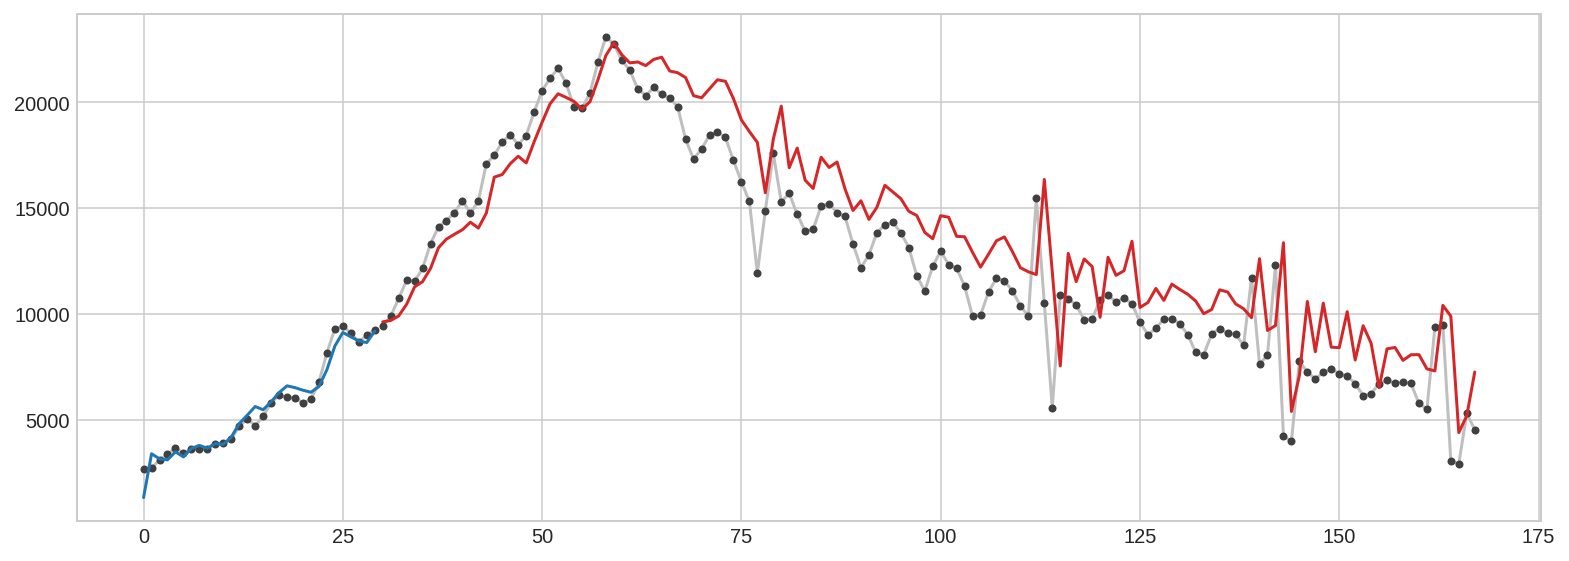

In [10]:
model_ls_i = Lasso(alpha = 0.1) 
model_ls_i.fit(X_i_train, y_i_train)
y_pred_ls_i = pd.Series(model_ls_i.predict(X_i_train), index=y_i_train.index)
y_fore_ls_i = pd.Series(model_ls_i.predict(X_i_test), index=y_i_test.index)

mape_ls_i = mean_absolute_percentage_error(y_i_test, y_fore_ls_i)

print("MAPE =", mape_ls_i)

ax = y_i_train.plot(**plot_params)
ax = y_i_test.plot(**plot_params)
ax = y_pred_ls_i.plot(ax=ax)
_ = y_fore_ls_i.plot(ax=ax, color='C3')

## Deaths

MAPE = 0.26423110443857967


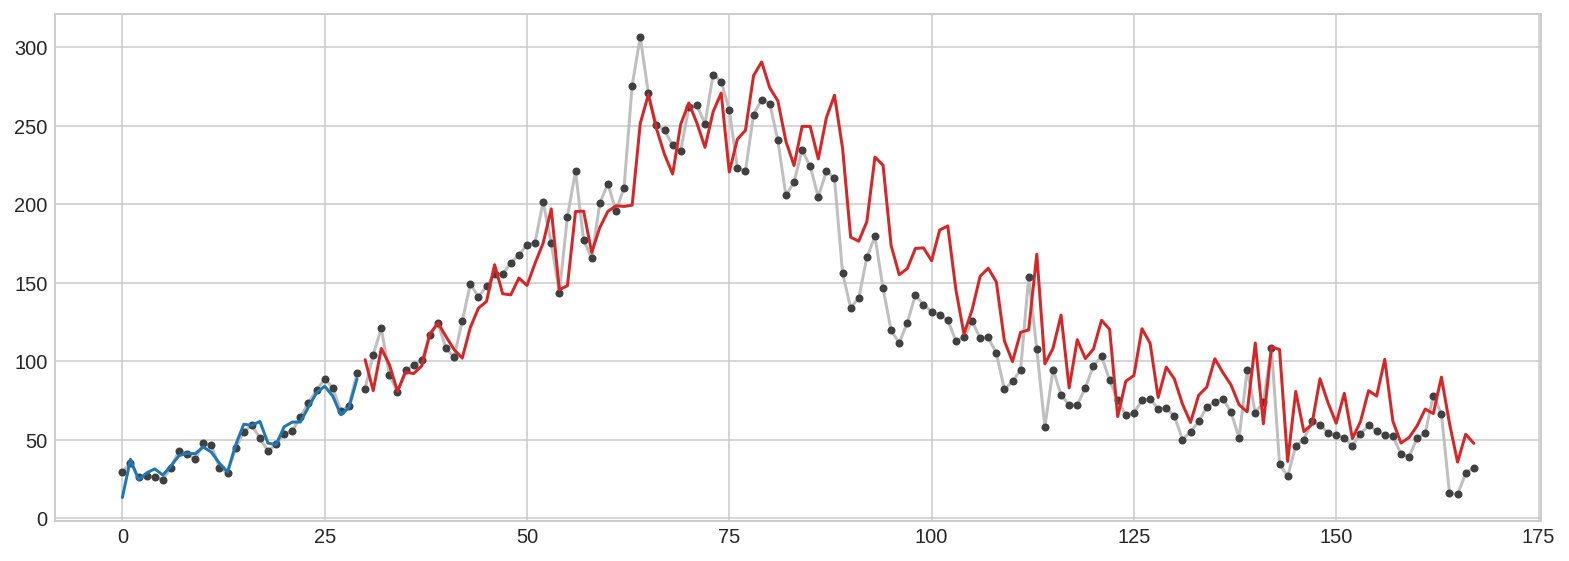

In [11]:

model_ls_d = Lasso(alpha = 0.1)
model_ls_d.fit(X_d_train, y_d_train)
y_pred_ls_d = pd.Series(model_ls_d.predict(X_d_train), index=y_d_train.index)
y_fore_ls_d = pd.Series(model_ls_d.predict(X_d_test), index=y_d_test.index)

mape_ls_d = mean_absolute_percentage_error(y_d_test, y_fore_ls_d)

print("MAPE =", mape_ls_d)


ax = y_d_train.plot(**plot_params)
ax = y_d_test.plot(**plot_params)
ax = y_pred_ls_d.plot(ax=ax)
_ = y_fore_ls_d.plot(ax=ax, color='C3')

# XGBoost

## Cases

MAPE = 0.32162574468473726


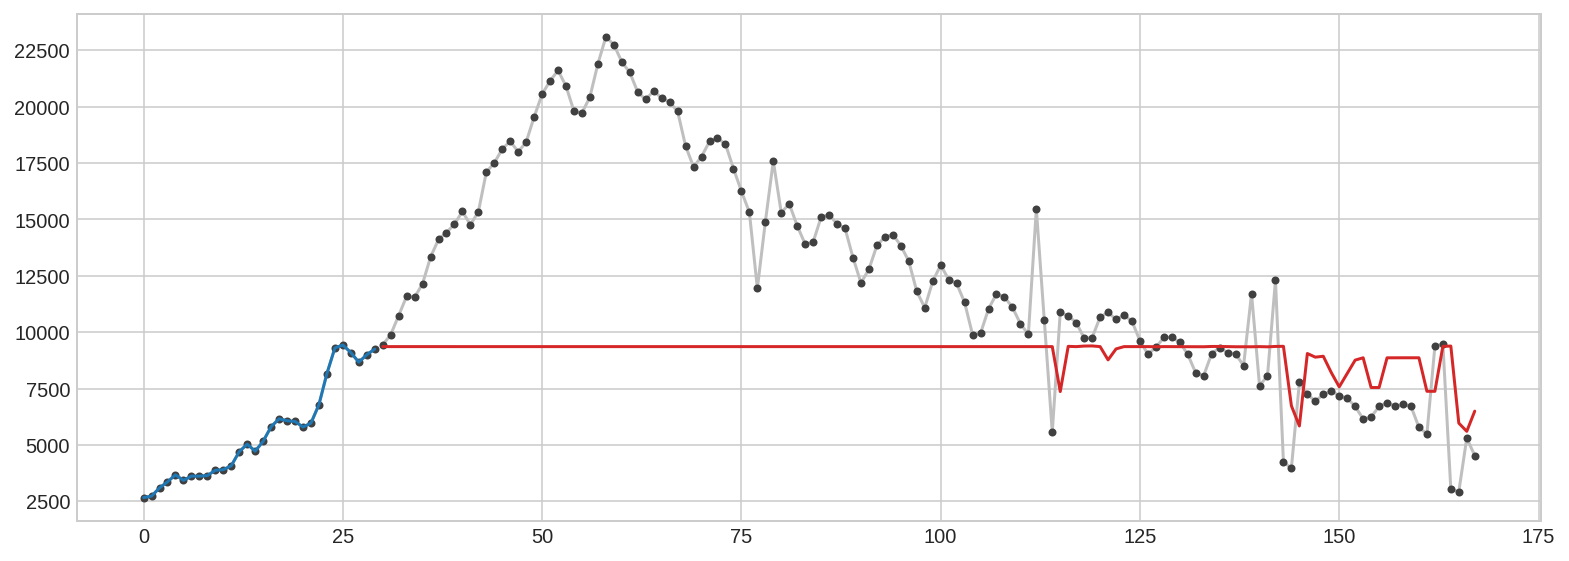

In [12]:
model_xg_i = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model_xg_i.fit(X_i_train, y_i_train)
y_pred_xg_i = pd.Series(model_xg_i.predict(X_i_train), index=y_i_train.index)
y_fore_xg_i = pd.Series(model_xg_i.predict(X_i_test), index=y_i_test.index)

mape_xg_i = mean_absolute_percentage_error(y_i_test, y_fore_xg_i)


print("MAPE =", mape_xg_i)


ax = y_i_train.plot(**plot_params)
ax = y_i_test.plot(**plot_params)
ax = y_pred_xg_i.plot(ax=ax)
_ = y_fore_xg_i.plot(ax=ax, color='C3')

## Deaths

MAPE = 0.4359194113011036


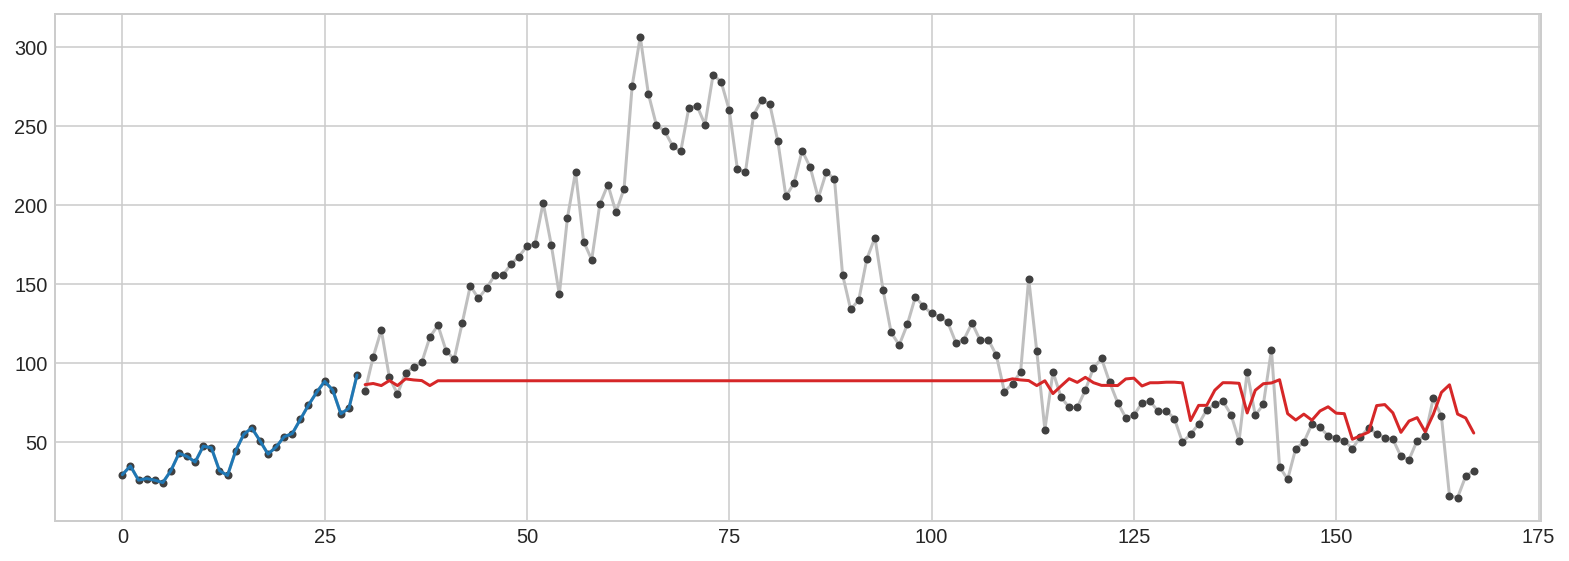

In [13]:
model_xg_d = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model_xg_d.fit(X_d_train, y_d_train)
y_pred_xg_d = pd.Series(model_xg_d.predict(X_d_train), index=y_d_train.index)
y_fore_xg_d = pd.Series(model_xg_d.predict(X_d_test), index=y_d_test.index)

mape_xg_d = mean_absolute_percentage_error(y_d_test, y_fore_xg_d)

print("MAPE =", mape_xg_d)


ax = y_d_train.plot(**plot_params)
ax = y_d_test.plot(**plot_params)
ax = y_pred_xg_d.plot(ax=ax)
_ = y_fore_xg_d.plot(ax=ax, color='C3')

# Elastic Net

## Cases

MAPE = 0.20166216652621438


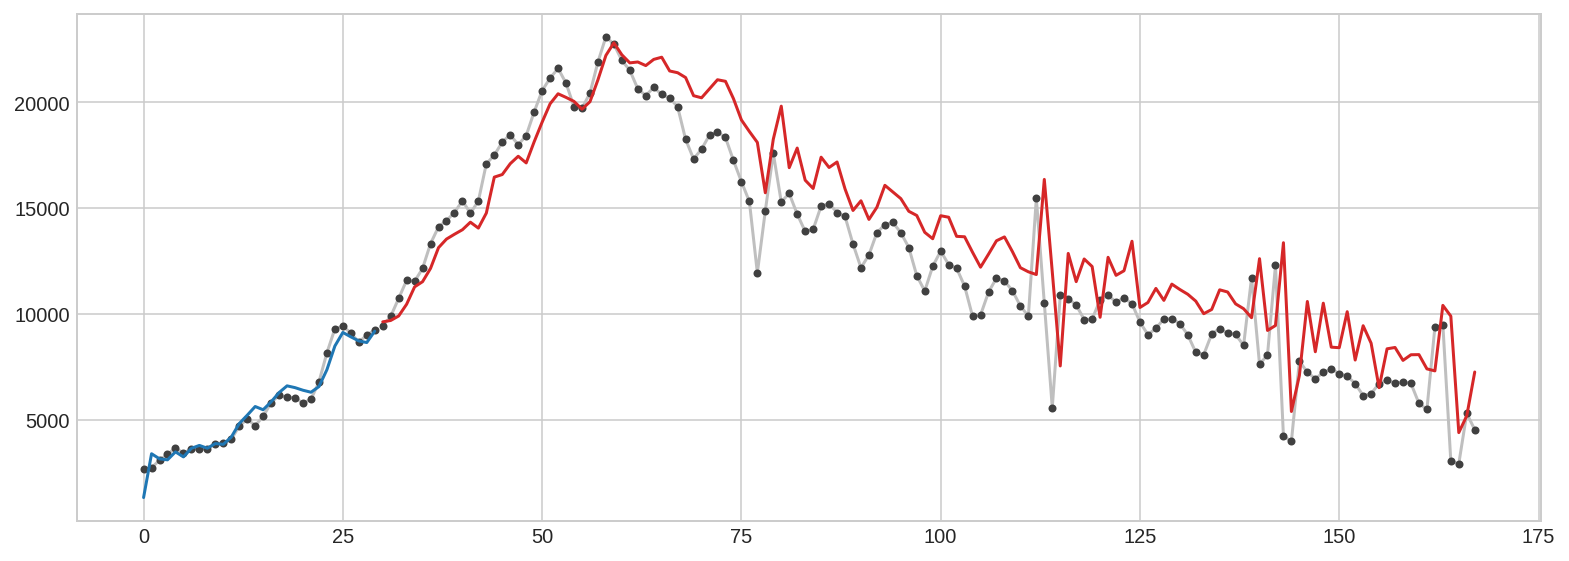

In [14]:
model_en_i = ElasticNet(alpha=0.5)
model_en_i.fit(X_i_train, y_i_train)
y_pred_en_i = pd.Series(model_en_i.predict(X_i_train), index=y_i_train.index)
y_fore_en_i = pd.Series(model_en_i.predict(X_i_test), index=y_i_test.index)

mape_en_i = mean_absolute_percentage_error(y_i_test, y_fore_en_i)


print("MAPE =", mape_en_i)


ax = y_i_train.plot(**plot_params)
ax = y_i_test.plot(**plot_params)
ax = y_pred_en_i.plot(ax=ax)
_ = y_fore_en_i.plot(ax=ax, color='C3')

## Deaths

MAPE = 0.2658622868295481


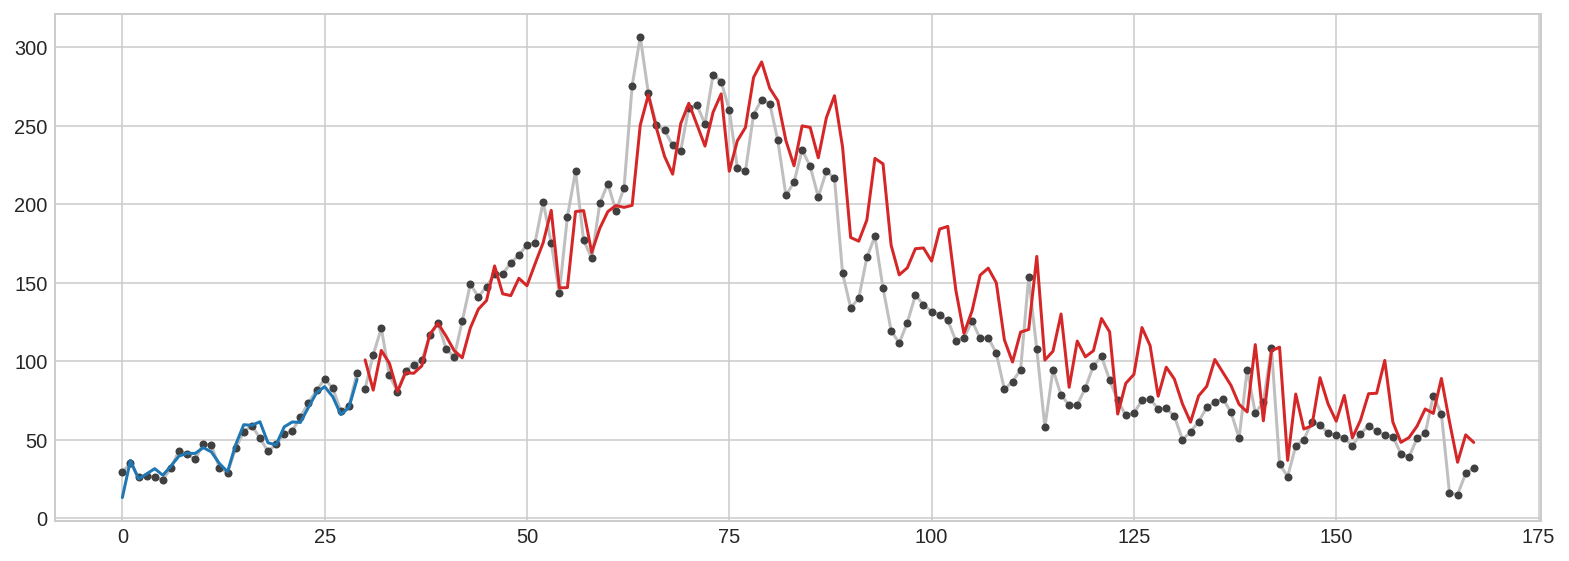

In [15]:
model_en_d = ElasticNet(alpha = 0.5)
model_en_d.fit(X_d_train, y_d_train)
y_pred_en_d = pd.Series(model_en_d.predict(X_d_train), index=y_d_train.index)
y_fore_en_d = pd.Series(model_en_d.predict(X_d_test), index=y_d_test.index)

mape_en_d = mean_absolute_percentage_error(y_d_test, y_fore_en_d)

print("MAPE =", mape_en_d)


ax = y_d_train.plot(**plot_params)
ax = y_d_test.plot(**plot_params)
ax = y_pred_en_d.plot(ax=ax)
_ = y_fore_en_d.plot(ax=ax, color='C3')

# Result Table

## Cases

In [16]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Test MAPE'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Linear Regression', 
                                                   'Ridge Regression',
                                                   'Lasso Regression',
                                                   'Elastic Net',
                                                   'XGBoost'],
                                                  [round(mape_lr_i,4), round(mape_rr_i,4), round(mape_lr_i,4), round(mape_en_i,4), round(mape_xg_i,4)]],
                            align=['left','center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error: Confirmed Cases",title_x=0.5)
fig.show()

## Deaths

In [17]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Test MAPE'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Linear Regression', 
                                                   'Ridge Regression',
                                                   'Lasso Regression',
                                                   'Elastic Net',
                                                   'XGBoost'],
                                                  [round(mape_lr_d,4), round(mape_rr_d,4), round(mape_lr_d,4), round(mape_en_d,4), round(mape_xg_d,4)]],
                            align=['left','center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error: Confirmed Deaths",title_x=0.5)
fig.show()